# Diffusion Transformers 

> we will train a DiT on MNIST conditioning on label.

> we will not do LDM in this case as the image is already in (32x32) which is usually the space in which DiTs function.


In this blog we will understand the architecture of the DiT which in many ways is very similar to ViT


[original paper](https://arxiv.org/pdf/2212.09748)  
[original code](https://github.com/facebookresearch/DiT/blob/main/models.py)

In [1]:
# Looad required libraries 

import torch 
import fastcore.all as fc
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

In [2]:
# Now say we have MNIST data in the shape of (N, 1, 28, 28)
# we will create a VAE model to generate new images similar to the training data. 

# Load MNIST data 

# Load MNIST data and resize it to 64x64
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Pad(2),
                                    torchvision.transforms.ToTensor(),
                                ])),
    batch_size=64, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Pad(2),
                                    torchvision.transforms.ToTensor(),
                                ])),
    batch_size=64, shuffle=False)

len(train_loader), len(val_loader)

(938, 157)

In [3]:
imgs, labels = next(iter(train_loader))
imgs.shape, labels.shape

(torch.Size([64, 1, 32, 32]), torch.Size([64]))

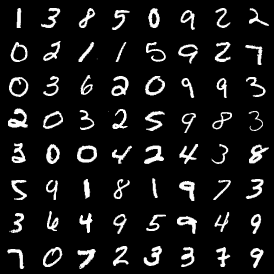

In [4]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(imgs, nrow=8, normalize=False))

## Patchify
32x32x1 image is patched using p=2, 4, 8 in the paper. so for example if we take 4. each patch is of size 4x4x1, we will ouput a `N_emb` vector for each patch. so that output of the layer will be (32x32x1)/(4x4x1) (64, N_emb). lets use 128 as `N_emb` here as we are learning MNIST digits here. In original paper they start with 768 for the base model and increase from der.

the easiest way to patch is use conv layer with kernel size and stride as patch_size. 

In [5]:
class Patchify(torch.nn.Module):
    def __init__(self, ims, ps, in_chans, embed_dim):
        super().__init__()
        self.total_patches = (ims/ps)**2
        self.proj = torch.nn.Conv2d(in_chans, embed_dim, kernel_size=ps, stride=ps, bias=True)
    
    def forward(self, x):
        B, C, H, W = x.shape
        out = self.proj(x)
        out = out.flatten(2).transpose(1, 2)
        return out
patch = Patchify(32, 4, 1, 128)
patch.total_patches

64.0

In [6]:
tokens = patch(imgs)
tokens.shape

torch.Size([64, 64, 128])

## Positional embedding 

we can add sin-cos embeddings are making this layer learnable. in the original paper this is learnable

In [7]:
pos_embed = torch.nn.Parameter(torch.zeros(1, int(patch.total_patches), 128))
tokens = tokens + pos_embed
tokens.shape

torch.Size([64, 64, 128])

In this model we have have to condition on label (or text or another image) and time.There are three ways we can add conditioning to the model. 
- prepend to the tokens and process them similar to [cls] token
- cross attention
- Adapative layer norm (AdaLN) block (used in stylegan originally)

we will see each of these and use one of it. In the papers authors used AdaLN as it adds the least Gflops and is the most compute efficient. 

before that, lets get label and time embeddings

## Label embedding
we have 10 labels + 1 null label (for classifier guidance) in this model.

In [8]:
class LabelEmbedding(torch.nn.Module):
    def __init__(self, num_classes, embed_dim, drop_out_prob=0.1):
        super().__init__()
        fc.store_attr()
        self.cfg_guide = drop_out_prob > 0
        self.embedding = torch.nn.Embedding(num_classes+self.cfg_guide, embed_dim)
    
    def forward(self, labels, train=True):
        if train and self.drop_out_prob > 0:
            drop_ids = torch.rand(labels.shape[0], device=labels.device) < self.drop_out_prob
            labels = torch.where(drop_ids, self.num_classes, labels)
        return self.embedding(labels)

le = LabelEmbedding(10, 128, 0.1)
le(labels)
label_emb = le(labels, train=True)
label_emb.shape

torch.Size([64, 128])

## Time embedding
I m not going deep into this but think of this as taking t as input and giving out a 128 dim vector. 

#TODO: I will add the intution  behind this later with mathematical roots for doing this.

copying the original function here.

In [9]:
class TimestepEmbedder(torch.nn.Module):
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        half = dim // 2
        freqs = torch.exp(
            -torch.log(torch.tensor(max_period)) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, t):
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb

In [10]:
# while training diffusion models, we use different timestep for each image
timesteps = torch.randint(0, 1000, (64,))
timestep_embedder = TimestepEmbedder(128)
timestep_embedder(timesteps)
te = timestep_embedder(timesteps)
te.shape

torch.Size([64, 128])

In [11]:
conditioning_tokens = te+label_emb
conditioning_tokens.shape

torch.Size([64, 128])

## Transformer block 

There are two different ways in which we can use attentions. 
- self-attention: in paper this is referred as `in-context` learning. we will prepend conditioning token to the original tokens and pass through transformer blocks
- cross-attention: in attn, k, v comes from conditioning and q comes from tokens. attention is calculated againt these and hence cross attention.

we will implement both of them below

In [12]:
transformer_inputs = torch.cat([conditioning_tokens.unsqueeze(1), tokens], dim=1)
transformer_inputs.shape

torch.Size([64, 65, 128])

In [13]:
class MHSA(torch.nn.Module):
    def __init__(self, dim, num_heads, dropout=0.0):
        super().__init__()
        assert dim % num_heads == 0, "dim must be divisible by num_heads"
        self.dim, self.num_heads, self.head_dim = dim, num_heads, dim // num_heads
        self.qkv_proj = torch.nn.Linear(dim, 3 * dim)
        self.output_proj = torch.nn.Linear(dim, dim)
        self.dropout_p = dropout

    def forward(self, x, mask=None):
        b, l, _ = x.shape
        qkv = self.qkv_proj(x).reshape(b, l, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None if mask is None else mask.squeeze(1), dropout_p=self.dropout_p if self.training else 0.0, is_causal=mask is None)
        return self.output_proj(attn.permute(0, 2, 1, 3).flatten(2))

mhsa = MHSA(128, 8)
mhsa(transformer_inputs).shape

torch.Size([64, 65, 128])

## Cross attention 

In [14]:
class MHCA(torch.nn.Module):
    def __init__(self, dim, num_heads, dropout=0.0):
        super().__init__()
        assert dim % num_heads == 0, "dim must be divisible by num_heads"
        self.dim, self.num_heads, self.head_dim = dim, num_heads, dim // num_heads
        self.scale = 1.0 / torch.sqrt(torch.tensor(self.head_dim))
        self.q_proj, self.kv_proj = torch.nn.Linear(dim, dim), torch.nn.Linear(dim, 2 * dim)
        self.output_proj = torch.nn.Linear(dim, dim)
        self.dropout_p = dropout
        
    def forward(self, x, context, mask=None):
        b, l, l_ctx = x.shape[0], x.shape[1], context.shape[1]
        q = self.q_proj(x).reshape(b, l, self.num_heads, self.head_dim).transpose(1, 2)
        kv = self.kv_proj(context).reshape(b, l_ctx, 2, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        k, v = kv[0], kv[1]
        attn_output = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=mask, dropout_p=self.dropout_p if self.training else 0.0)
        return self.output_proj(attn_output.transpose(1, 2).reshape(b, l, self.dim))
    
mhca = MHCA(128, 8)
mhca(tokens, conditioning_tokens.unsqueeze(1)).shape

torch.Size([64, 64, 128])

## Adaptive layer norm (adaLN) block
In the papers, authors use the following block 

<img src="images/dit1.png" width="500" />

so we will use `MHSA` attn as implemented above. 

- The adaLN module outputs $\gamma_{1}$, $\beta_{1}$  and  $\gamma_{2}$, $\beta_{2}$ (scale and shift applied to layernorm outputs). we can see in the above picture how they are applied 
- The  $\alpha_{1}$ and $\alpha_{2}$  is scale applied prior to any residual connections within the DiT block. we zero initalize them so that the entire block works like an identity function first. 

in the original code this is not clear, so we will modify accordingly.

In [15]:
class Mlp(torch.nn.Module):
    def __init__(self, in_features, hidden_features=None, act_layer=torch.nn.GELU, drop=0.):
        super().__init__()
        self.fc1 = torch.nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.drop = torch.nn.Dropout(drop)
        self.fc2 = torch.nn.Linear(hidden_features, in_features)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x
    
def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

class DiTBlock(torch.nn.Module):
    def __init__(self, hidden_size, num_heads, mlp_ratio=4.0, **block_kwargs):
        super().__init__()
        self.norm1 = torch.nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.attn = MHSA(hidden_size, num_heads=num_heads, **block_kwargs)
        self.norm2 = torch.nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        mlp_hidden_dim = int(hidden_size * mlp_ratio)
        approx_gelu = lambda: torch.nn.GELU(approximate="tanh")
        self.mlp = Mlp(in_features=hidden_size, hidden_features=mlp_hidden_dim, act_layer=approx_gelu, drop=0)
        self.adaLN_modulation = torch.nn.Sequential(
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_size, 4 * hidden_size, bias=True)
        )
        self.adaLN_zero = torch.nn.Sequential(
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_size, 2 * hidden_size, bias=True)
        )
        self.__init_weights()
    
    def __init_weights(self):
        torch.nn.init.zeros_(self.adaLN_zero[1].weight)
        torch.nn.init.zeros_(self.adaLN_zero[1].bias)

    def forward(self, x, c):
        alpha1, alpha2 = self.adaLN_zero(c).chunk(2, dim=1)
        scale1, shift1, scale2, shift2 = self.adaLN_modulation(c).chunk(4, dim=1)

        y = self.norm1(x)
        y = modulate(y, shift1, scale1)
        y = self.attn(y)
        x = x + alpha1.unsqueeze(1) * y

        y = self.norm2(y)
        y = modulate(y, shift2, scale2)
        y = self.mlp(y)
        y = x + alpha2.unsqueeze(1) * y
        return x
    
    
db = DiTBlock(128, 8)
out = db(tokens, conditioning_tokens)
print(out.shape)
        

torch.Size([64, 64, 128])


## Transformer Decoder 
After encoding the images and passing through transformer blocks we need to decode them back to image space. We use a standard linear decoder to do this; we apply the final layer norm (adaptive if using adaLN) and linearly decode each token into a p×p×2C tensor, where C is the number of channels in the spatial input to DiT. Finally, we rearrange the decoded tokens into their original spatial layout to get the predicted noise and covariance.


In [16]:
class FinalLayer(torch.nn.Module):
    """
    The final layer of DiT.
    """
    def __init__(self, hidden_size, patch_size, out_channels):
        super().__init__()
        self.norm_final = torch.nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.linear = torch.nn.Linear(hidden_size, patch_size * patch_size * out_channels, bias=True)
        self.adaLN_modulation = torch.nn.Sequential(
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_size, 2 * hidden_size, bias=True)
        )

    def forward(self, x, c):
        shift, scale = self.adaLN_modulation(c).chunk(2, dim=1)
        x = modulate(self.norm_final(x), shift, scale)
        x = self.linear(x)
        return x

In [17]:
output = FinalLayer(128, 4, 1)(out, conditioning_tokens)
output.shape

torch.Size([64, 64, 16])

In [18]:
class DiT(torch.nn.Module):
    def __init__(self, image_size, patch_size, in_chans, num_labels, hidden_size, num_heads, num_layers, mlp_ratio=4.0, **block_kwargs):
        super().__init__()
        fc.store_attr()
        self.patch = Patchify(image_size, patch_size, in_chans, hidden_size)
        self.pos_embed = torch.nn.Parameter(torch.zeros(1, int(self.patch.total_patches), hidden_size))
        self.label_embed = LabelEmbedding(num_labels,  hidden_size, 0.1) #cfg gudience is hardcoded here
        self.timestep_embedder = TimestepEmbedder(hidden_size)
        self.layers = torch.nn.ModuleList([DiTBlock(hidden_size, num_heads, mlp_ratio, **block_kwargs) for _ in range(num_layers)])
        self.final_layer = FinalLayer(hidden_size, patch_size, in_chans)
        self.out_channels = in_chans

    
    def unpatchify(self, x):
        """
        x: (N, T, patch_size**2 * C)
        imgs: (N, H, W, C)
        """
        c = self.out_channels
        p = self.patch_size
        h = w = int(x.shape[1] ** 0.5)
        assert h * w == x.shape[1]

        x = x.reshape(shape=(x.shape[0], h, w, p, p, c))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], c, h * p, h * p))
        return imgs
        
    def forward(self, x, labels, timesteps):
        x = self.patch(x)
        x = x + self.pos_embed
        
        t = self.timestep_embedder(timesteps)
        c = self.label_embed(labels)
        c = c+t 
        for layer in self.layers:
            x = layer(x, c)
        x = self.final_layer(x, c)
        x = self.unpatchify(x)
        return x
        

In [19]:
model = DiT(image_size=32, patch_size=4, in_chans=1, num_labels=10, hidden_size=512, num_heads=8, num_layers=12)
model

DiT(
  (patch): Patchify(
    (proj): Conv2d(1, 512, kernel_size=(4, 4), stride=(4, 4))
  )
  (label_embed): LabelEmbedding(
    (embedding): Embedding(11, 512)
  )
  (timestep_embedder): TimestepEmbedder(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (layers): ModuleList(
    (0-11): 12 x DiTBlock(
      (norm1): LayerNorm((512,), eps=1e-06, elementwise_affine=False)
      (attn): MHSA(
        (qkv_proj): Linear(in_features=512, out_features=1536, bias=True)
        (output_proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (norm2): LayerNorm((512,), eps=1e-06, elementwise_affine=False)
      (mlp): Mlp(
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (act): GELU(approximate='tanh')
        (drop): Dropout(p=0, inplace=False)
        (fc2): Linear(in_features=2048, out_features=512, bias=True)
      

In [20]:
out = model(imgs, labels, timesteps)
out.shape

torch.Size([64, 1, 32, 32])

In [21]:
params = sum(p.numel() for p in model.parameters())
params


57690128

Since the architecture is implemented now we will use it to train on MNIST dataset. 

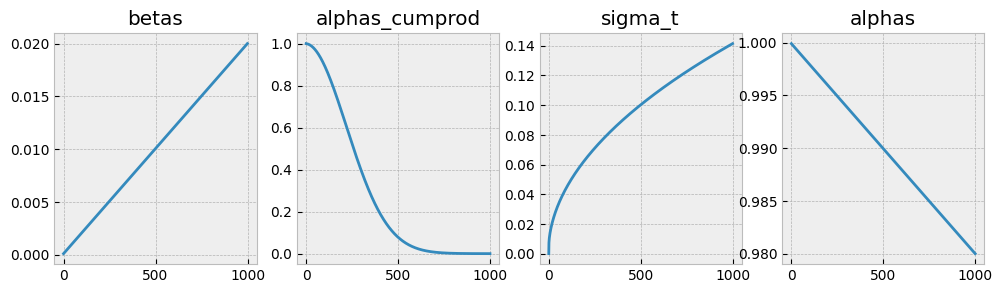

In [22]:
class ModelArgs:
    T = 1000
    beta_min = 0.0001 
    beta_max = 0.02
    betas = torch.linspace(beta_min, beta_max, T)
    alphas = 1-betas 
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    alphas_cumprod_prev =  torch.cat([torch.tensor([1.0]), alphas_cumprod[:-1]], dim=0)
    sigma_t = torch.sqrt((1-alphas_cumprod_prev)/(1-alphas_cumprod)*betas)

cfg = ModelArgs()
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax.flat[0].plot(cfg.betas)
ax.flat[1].plot(cfg.alphas_cumprod)
ax.flat[2].plot(cfg.sigma_t)
ax.flat[3].plot(cfg.alphas)
ax.flat[0].set_title('betas')
ax.flat[1].set_title('alphas_cumprod')
ax.flat[2].set_title('sigma_t')
ax.flat[3].set_title('alphas')
plt.show()

## Forward markov process 

$$
x_t = \sqrt{\bar{\alpha}_{t}} x_0 + \sqrt{1-\bar{\alpha}_{t}} \epsilon_{t}
$$

In [23]:
def forward_step(cfg, x0, t, noise=None):
    alpha_t = cfg.alphas_cumprod[t]
    if noise is None:
        noise = torch.randn_like(x0)
    xt = torch.sqrt(alpha_t) * x0 + torch.sqrt(1 - alpha_t) * noise
    return xt

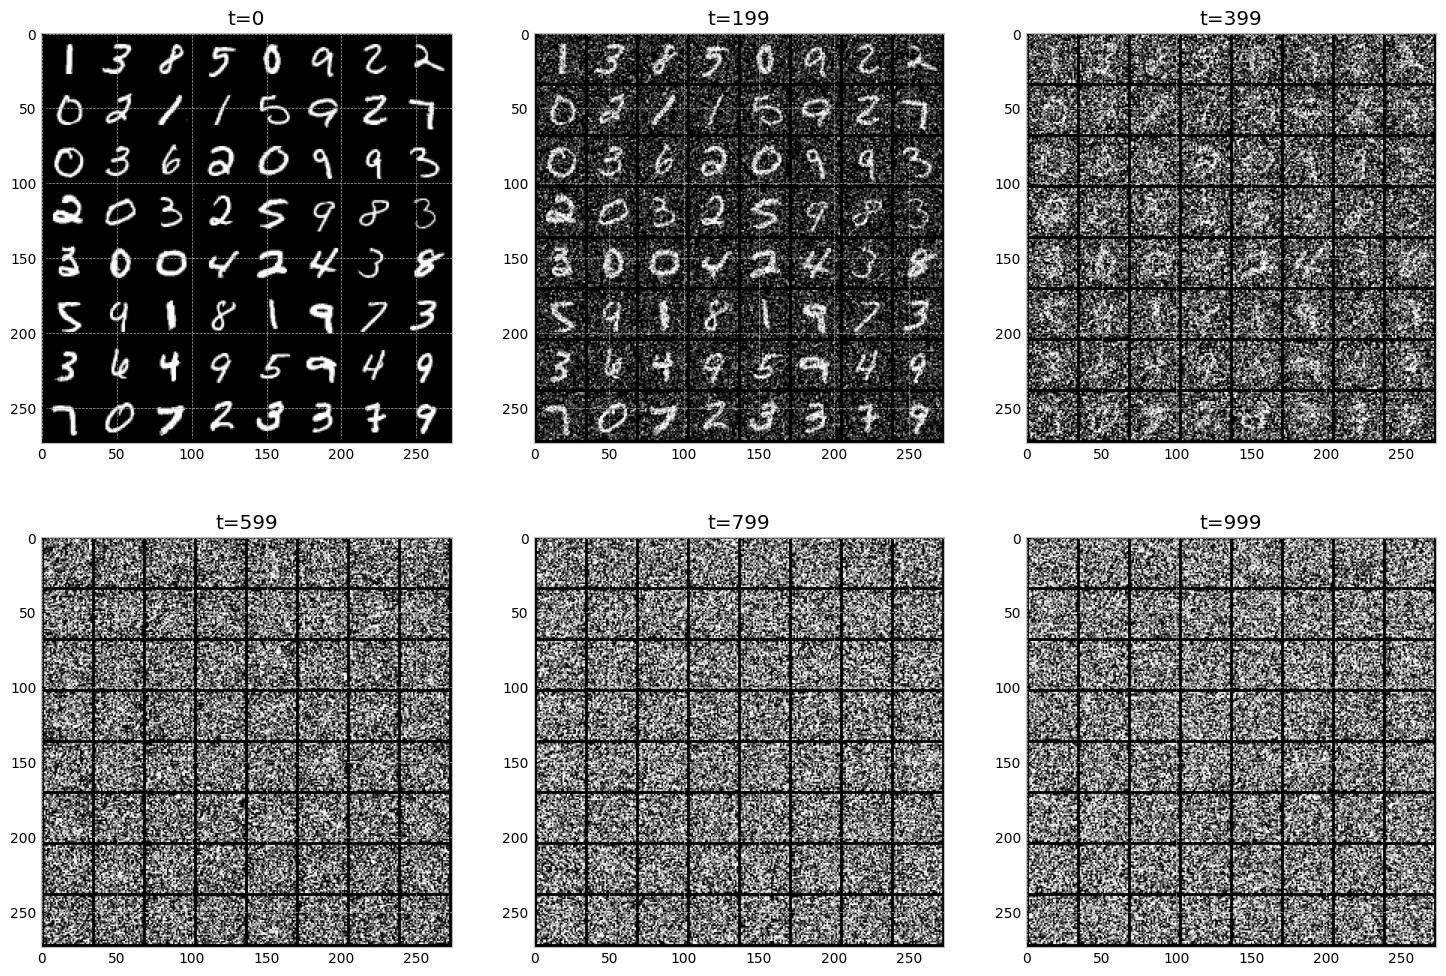

In [24]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12))
for n, i in enumerate([0, 199, 399, 599, 799, 999]):
    imgsn = 2*imgs-1 
    xt = forward_step(cfg, imgsn, i)
    xt = xt.clamp(-1, 1)
    img = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(xt[:64], nrow=8, normalize=True))
    ax.flat[n].imshow(img)
    ax.flat[n].set_title(f't={i}')
plt.show()

In [25]:
# During inference/validation
@torch.no_grad()
def sample_ddpm(cfg, model, n_samples, device):
    # Start from pure noise
    if isinstance(n_samples, int):
        x = torch.randn((n_samples, 1, 32, 32)).to(device)
        labels = torch.randint(0, 10, (n_samples,)).to(device)
    else:
        x = n_samples 
        n_samples = x.shape[0]
    img_list = []
    
    for t in tqdm(reversed(range(cfg.T)), desc='sampling loop time step'):
        t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
        
        # Predict noise
        pred_noise = model(x, labels, t_batch)
        
        # Update sample with improved scheduler
        alpha = cfg.alphas[t]
        alpha_hat = cfg.alphas_cumprod[t]
        sigma = cfg.sigma_t[t]
        
        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)
            
        posterior_mean = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * pred_noise) 
        posterior_std = sigma * noise
        x = posterior_mean + posterior_std

        if t in [0, 199, 399, 599, 799, 999]:
            img = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(x.clamp(-1, 1).cpu(), nrow=8, normalize=True))
            img_list.append(img)
    
    return x.clamp(-1, 1), img_list

sampling loop time step: 81it [00:01, 89.55it/s]

sampling loop time step: 1000it [00:10, 91.59it/s]


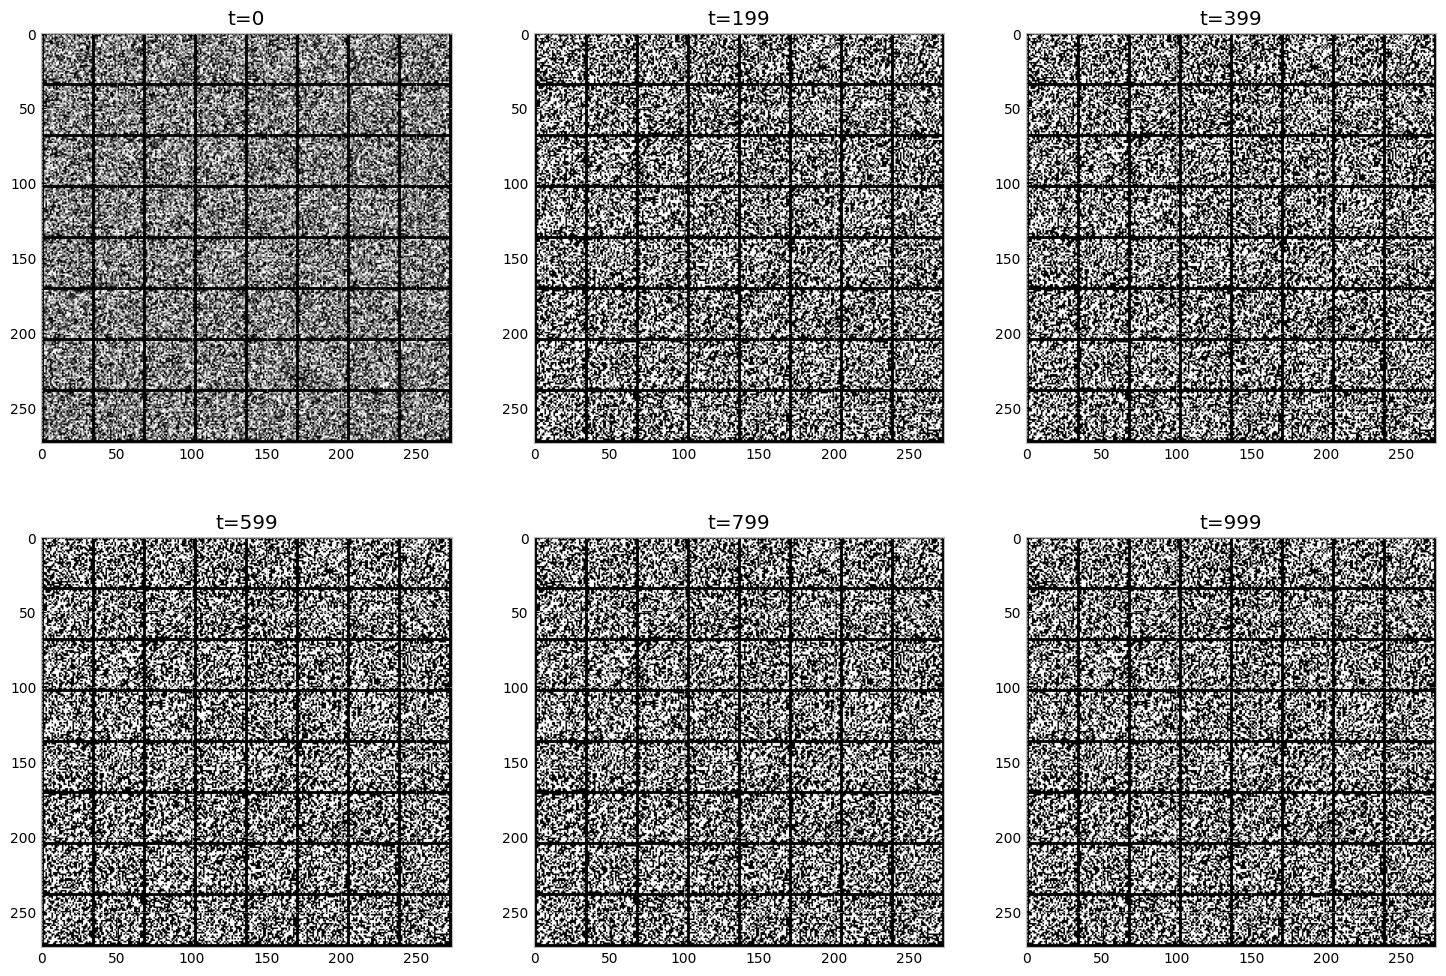

In [26]:
final_img, img_list = sample_ddpm(cfg, model.cuda(), 64, "cuda:0")

fig, ax = plt.subplots(2, 3, figsize=(18, 12))
for n, (img, t) in enumerate(zip(img_list, [0, 199, 399, 599, 799, 999])):
    ax.flat[n].imshow(img)
    ax.flat[n].set_title(f't={t}')
plt.show()


In [27]:
# we will add EMA weights to the model. 
import copy

def exists(val):
    return val is not None

class EMA():
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
    def update_average(self, old, new):
        if not exists(old):
            return new
        return old * self.beta + (1 - self.beta) * new

ema = EMA(beta=0.9999)
ema_model = copy.deepcopy(model)

In [28]:
store_path = fc.Path("dit_generated")
store_path.mkdir(parents=True, exist_ok=True)

In [29]:
epochs = 100
device = torch.device("cuda")
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4) #suggested by cursor. 
total_steps = len(train_loader) * epochs
noise = torch.randn((64, 1, 32, 32), device=device)

iter = 0 
train_loss = []

for epoch in range(epochs):
    model.train()
    epoch_loss = []
    with tqdm(train_loader, unit="batch") as tepoch:
        for batch in tepoch:
            optimizer.zero_grad()
            
            x0, labels = batch
            t = torch.randint(0, cfg.T, (x0.shape[0],), device=x0.device)
            x0 = 2*x0 -1  # scale to -1 to 1
            noise = torch.randn_like(x0)
            xt = forward_step(cfg, x0, t.view(-1, 1, 1, 1), noise)
            model_output = model(xt.to(device), labels.to(device), t.to(device))
            
            loss = torch.nn.functional.mse_loss(model_output, noise.to(device))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Add gradient clipping
            optimizer.step()

            #calculate loss 
            tepoch.set_postfix(loss=loss.item())
            epoch_loss.append(loss.item())
                    
            #update ema model 
            for current_params, ma_params in zip(model.parameters(), ema_model.parameters()):
                    old_weight, up_weight = ma_params.data, current_params.data
                    ma_params.data = ema.update_average(old_weight, up_weight)
    
    train_loss.extend(epoch_loss)
    epoch_loss = torch.mean(torch.tensor(epoch_loss))
    store = {
         "ema_model": ema_model.state_dict(),
         "model": model.state_dict(),
         "train_loss": epoch_loss
    }
    torch.save(store, store_path/f"ema_model_{epoch}_{epoch_loss:3f}.pth")
    print(f"Epoch {epoch} completed: train loss {epoch_loss}")
    #TODO: calculate some metric between generated images and original images

    ema_model.eval()
    out, _ = sample_ddpm(cfg, ema_model, 128, device)
    img = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(out.clamp(-1, 1).cpu(), nrow=8, normalize=True))
    img.save(store_path/f"generated_images_{epoch}.png")
        

100%|██████████| 938/938 [00:30<00:00, 30.87batch/s, loss=0.0324]


Epoch 0 completed: train loss 0.08259700983762741


sampling loop time step: 1000it [00:17, 55.56it/s]
100%|██████████| 938/938 [00:29<00:00, 31.45batch/s, loss=0.0328]


Epoch 1 completed: train loss 0.04163716360926628


sampling loop time step: 1000it [00:17, 55.59it/s]
100%|██████████| 938/938 [00:29<00:00, 31.28batch/s, loss=0.027] 


Epoch 2 completed: train loss 0.03678903356194496


sampling loop time step: 1000it [00:17, 55.59it/s]
100%|██████████| 938/938 [00:30<00:00, 31.18batch/s, loss=0.0494]


Epoch 3 completed: train loss 0.03478582203388214


sampling loop time step: 1000it [00:18, 55.45it/s]
100%|██████████| 938/938 [00:29<00:00, 31.32batch/s, loss=0.0429]


Epoch 4 completed: train loss 0.03319094330072403


sampling loop time step: 1000it [00:18, 55.48it/s]
100%|██████████| 938/938 [00:30<00:00, 31.19batch/s, loss=0.0234]


Epoch 5 completed: train loss 0.030911896377801895


sampling loop time step: 1000it [00:17, 55.57it/s]
100%|██████████| 938/938 [00:29<00:00, 31.45batch/s, loss=0.0407]


Epoch 6 completed: train loss 0.030201349407434464


sampling loop time step: 1000it [00:18, 55.53it/s]
100%|██████████| 938/938 [00:29<00:00, 31.49batch/s, loss=0.0361]


Epoch 7 completed: train loss 0.028025835752487183


sampling loop time step: 1000it [00:17, 55.61it/s]
100%|██████████| 938/938 [00:29<00:00, 31.62batch/s, loss=0.045] 


Epoch 8 completed: train loss 0.027302632108330727


sampling loop time step: 1000it [00:17, 55.60it/s]
100%|██████████| 938/938 [00:29<00:00, 31.40batch/s, loss=0.0312]


Epoch 9 completed: train loss 0.026541832834482193


sampling loop time step: 1000it [00:17, 55.56it/s]
100%|██████████| 938/938 [00:29<00:00, 31.44batch/s, loss=0.0211]


Epoch 10 completed: train loss 0.025802716612815857


sampling loop time step: 1000it [00:18, 55.55it/s]
100%|██████████| 938/938 [00:29<00:00, 31.39batch/s, loss=0.0209]


Epoch 11 completed: train loss 0.02555915340781212


sampling loop time step: 1000it [00:18, 55.53it/s]
100%|██████████| 938/938 [00:30<00:00, 31.27batch/s, loss=0.022] 


Epoch 12 completed: train loss 0.025007808580994606


sampling loop time step: 1000it [00:18, 55.55it/s]
100%|██████████| 938/938 [00:29<00:00, 31.35batch/s, loss=0.0299]


Epoch 13 completed: train loss 0.024737359955906868


sampling loop time step: 1000it [00:18, 55.51it/s]
100%|██████████| 938/938 [00:29<00:00, 31.42batch/s, loss=0.0225]


Epoch 14 completed: train loss 0.024401308968663216


sampling loop time step: 1000it [00:17, 55.59it/s]
100%|██████████| 938/938 [00:29<00:00, 31.32batch/s, loss=0.0294]


Epoch 15 completed: train loss 0.023914484307169914


sampling loop time step: 1000it [00:17, 55.58it/s]
100%|██████████| 938/938 [00:29<00:00, 31.31batch/s, loss=0.0221]


Epoch 16 completed: train loss 0.024179751053452492


sampling loop time step: 1000it [00:17, 55.56it/s]
100%|██████████| 938/938 [00:29<00:00, 31.28batch/s, loss=0.0196]


Epoch 17 completed: train loss 0.02398024871945381


sampling loop time step: 1000it [00:18, 55.52it/s]
100%|██████████| 938/938 [00:30<00:00, 31.22batch/s, loss=0.0229]


Epoch 18 completed: train loss 0.023313885554671288


sampling loop time step: 1000it [00:17, 55.57it/s]
100%|██████████| 938/938 [00:30<00:00, 31.21batch/s, loss=0.0151]


Epoch 19 completed: train loss 0.02379200980067253


sampling loop time step: 1000it [00:18, 55.54it/s]
100%|██████████| 938/938 [00:29<00:00, 31.29batch/s, loss=0.0196]


Epoch 20 completed: train loss 0.02351393550634384


sampling loop time step: 1000it [00:17, 55.57it/s]
100%|██████████| 938/938 [00:29<00:00, 31.31batch/s, loss=0.0301]


Epoch 21 completed: train loss 0.02311156503856182


sampling loop time step: 1000it [00:18, 55.55it/s]
100%|██████████| 938/938 [00:29<00:00, 31.28batch/s, loss=0.0199]


Epoch 22 completed: train loss 0.023307938128709793


sampling loop time step: 1000it [00:17, 55.57it/s]
100%|██████████| 938/938 [00:29<00:00, 31.33batch/s, loss=0.0204]


Epoch 23 completed: train loss 0.022776639088988304


sampling loop time step: 1000it [00:18, 55.50it/s]
100%|██████████| 938/938 [00:29<00:00, 31.29batch/s, loss=0.02]  


Epoch 24 completed: train loss 0.022794287651777267


sampling loop time step: 1000it [00:17, 55.57it/s]
100%|██████████| 938/938 [00:30<00:00, 31.26batch/s, loss=0.0209]


Epoch 25 completed: train loss 0.022581057623028755


sampling loop time step: 1000it [00:18, 55.49it/s]
100%|██████████| 938/938 [00:30<00:00, 31.25batch/s, loss=0.0167]


Epoch 26 completed: train loss 0.02283741906285286


sampling loop time step: 1000it [00:17, 55.56it/s]
100%|██████████| 938/938 [00:30<00:00, 31.23batch/s, loss=0.0173]


Epoch 27 completed: train loss 0.022457025945186615


sampling loop time step: 1000it [00:18, 55.55it/s]
100%|██████████| 938/938 [00:29<00:00, 31.27batch/s, loss=0.0276]


Epoch 28 completed: train loss 0.022711114957928658


sampling loop time step: 1000it [00:17, 55.61it/s]
100%|██████████| 938/938 [00:29<00:00, 31.31batch/s, loss=0.0213]


Epoch 29 completed: train loss 0.022349955514073372


sampling loop time step: 1000it [00:17, 55.56it/s]
100%|██████████| 938/938 [00:29<00:00, 31.27batch/s, loss=0.0149]


Epoch 30 completed: train loss 0.022195160388946533


sampling loop time step: 1000it [00:17, 55.59it/s]
100%|██████████| 938/938 [00:29<00:00, 31.37batch/s, loss=0.0195]


Epoch 31 completed: train loss 0.022639770060777664


sampling loop time step: 1000it [00:17, 55.56it/s]
100%|██████████| 938/938 [00:29<00:00, 31.36batch/s, loss=0.0164]


Epoch 32 completed: train loss 0.021949604153633118


sampling loop time step: 1000it [00:17, 55.61it/s]
100%|██████████| 938/938 [00:29<00:00, 31.33batch/s, loss=0.0215]


Epoch 33 completed: train loss 0.022508224472403526


sampling loop time step: 1000it [00:17, 55.61it/s]
100%|██████████| 938/938 [00:29<00:00, 31.36batch/s, loss=0.0215]


Epoch 34 completed: train loss 0.021791255101561546


sampling loop time step: 1000it [00:17, 55.60it/s]
100%|██████████| 938/938 [00:29<00:00, 31.37batch/s, loss=0.0167]


Epoch 35 completed: train loss 0.022038618102669716


sampling loop time step: 1000it [00:17, 55.61it/s]
100%|██████████| 938/938 [00:29<00:00, 31.34batch/s, loss=0.0271]


Epoch 36 completed: train loss 0.022082611918449402


sampling loop time step: 1000it [00:17, 55.57it/s]
100%|██████████| 938/938 [00:29<00:00, 31.31batch/s, loss=0.0273]


Epoch 37 completed: train loss 0.021859541535377502


sampling loop time step: 1000it [00:17, 55.57it/s]
100%|██████████| 938/938 [00:29<00:00, 31.31batch/s, loss=0.0319] 


Epoch 38 completed: train loss 0.02206292189657688


sampling loop time step: 1000it [00:17, 55.64it/s]
100%|██████████| 938/938 [00:29<00:00, 31.37batch/s, loss=0.0309] 


Epoch 39 completed: train loss 0.021993225440382957


sampling loop time step: 1000it [00:17, 55.63it/s]
100%|██████████| 938/938 [00:29<00:00, 31.38batch/s, loss=0.0205]


Epoch 40 completed: train loss 0.0218812208622694


sampling loop time step: 1000it [00:17, 55.61it/s]
100%|██████████| 938/938 [00:29<00:00, 31.35batch/s, loss=0.0279]


Epoch 41 completed: train loss 0.02172354981303215


sampling loop time step: 1000it [00:17, 55.63it/s]
100%|██████████| 938/938 [00:29<00:00, 31.38batch/s, loss=0.0239]


Epoch 42 completed: train loss 0.02158082090318203


sampling loop time step: 1000it [00:17, 55.59it/s]
100%|██████████| 938/938 [00:29<00:00, 31.33batch/s, loss=0.029] 


Epoch 43 completed: train loss 0.021938355639576912


sampling loop time step: 1000it [00:17, 55.60it/s]
100%|██████████| 938/938 [00:29<00:00, 31.32batch/s, loss=0.026]  


Epoch 44 completed: train loss 0.021596424281597137


sampling loop time step: 1000it [00:17, 55.65it/s]
100%|██████████| 938/938 [00:29<00:00, 31.35batch/s, loss=0.023] 


Epoch 45 completed: train loss 0.02180684357881546


sampling loop time step: 1000it [00:17, 55.59it/s]
100%|██████████| 938/938 [00:29<00:00, 31.29batch/s, loss=0.021] 


Epoch 46 completed: train loss 0.02160792425274849


sampling loop time step: 1000it [00:17, 55.61it/s]
100%|██████████| 938/938 [00:29<00:00, 31.36batch/s, loss=0.0224]


Epoch 47 completed: train loss 0.021451769396662712


sampling loop time step: 1000it [00:17, 55.60it/s]
100%|██████████| 938/938 [00:29<00:00, 31.46batch/s, loss=0.0249]


Epoch 48 completed: train loss 0.02144145965576172


sampling loop time step: 1000it [00:17, 55.62it/s]
100%|██████████| 938/938 [00:29<00:00, 31.51batch/s, loss=0.0125] 


Epoch 49 completed: train loss 0.021518278867006302


sampling loop time step: 1000it [00:17, 55.60it/s]


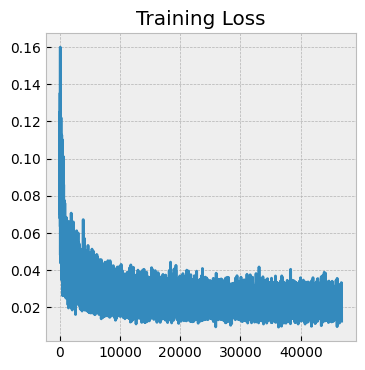

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(train_loss[100:])
plt.title("Training Loss")
plt.show()